# VAE (Variational Auto Encoder)
In this notebook we'll train a VAE model to generate digit images using the MNIST data set.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt

np.random.seed(42)
tf.set_random_seed(42)

%matplotlib inline

In [2]:
mnist = input_data.read_data_sets('MNIST_data')
input_size = 784
num_digits = 10

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


These are the hyperparameters we're going to use.

Feel free to play with different values to get a feeling how the model is affected.

In [3]:
params = {
    'encoder_layers': [128],
    'decoder_layers': [128],
    'digit_classification_layers': [128],
    'decoder_std': 0.5,
    'z_dim': 10,
    'activation': tf.nn.sigmoid,
    'batch_size': 100,
    'epochs': 20,
    'learning_rate': 0.001,
    'digit_classification_weight': 10.0
}

# Model
The mode is composed of three parts:
1. Given $x$ (image), encode it into a distribution over the latent space.
2. Given $z$ in latent space (code representation of an image), decode it into the image it represents.
3. Given $x$, classify its digit by mapping it to a layer of size 10 where the i'th value contains the probability of the i'th digit.

The first two parts are the vanilla VAE framework.

The last one is used as an auxiliary task (see [MTL](http://ruder.io/multi-task/index.html)), which will enforce some of the latent dimensions to encode the digit found in an image. This will allow us to generate images of whatever digit we want.

In [4]:
def encoder(x, layers):
    for layer in layers:
        x = tf.layers.dense(x, layer, activation=params['activation'])
    mu = tf.layers.dense(x, params['z_dim'])
    var = 1e-5 + tf.exp(tf.layers.dense(x, params['z_dim']))
    return mu, var


def decoder(z, layers):
    for layer in layers:
        z = tf.layers.dense(z, layer, activation=params['activation'])
    mu = tf.layers.dense(z, input_size)
    return tf.nn.sigmoid(mu)


def digit_classifier(x, layers):
    for layer in layers:
        x = tf.layers.dense(x, layer, activation=params['activation'])
    logits = tf.layers.dense(x, num_digits)
    return logits

In [5]:
images = tf.placeholder(tf.float32, [None, input_size])
digits = tf.placeholder(tf.int32, [None])

# encode an image into a distribution over the latent space
encoder_mu, encoder_var = encoder(images, params['encoder_layers'])

# sample a vector from the latent space
eps = tf.random_normal([tf.shape(images)[0], params['z_dim']], mean=0.0, stddev=1.0)
z = encoder_mu + tf.sqrt(encoder_var) * eps

# use the first dimensions to classify the digit
digit_logits = digit_classifier(images, params['digit_classification_layers'])
digit_prob = tf.nn.softmax(digit_logits)

# decode the code in the latent space to the image
decoder_mu = decoder(tf.concat([z, digit_prob], axis=1), params['decoder_layers'])

In [6]:
loss_encode = -0.5 * tf.reduce_sum(1 + tf.log(encoder_var) - encoder_mu ** 2 - encoder_var, axis=1)
loss_decode = -tf.reduce_sum(tf.contrib.distributions.Normal(
    decoder_mu, params['decoder_std']).log_prob(images), axis=1)
loss_auto_encode = tf.reduce_mean(loss_encode + loss_decode, axis=0)

loss_digit_classifier = params['digit_classification_weight'] * tf.reduce_mean(
    tf.nn.sparse_softmax_cross_entropy_with_logits(labels=digits, logits=digit_logits), axis=0)

loss = loss_auto_encode + loss_digit_classifier

train_op = tf.train.AdamOptimizer(params['learning_rate']).minimize(loss)

# Train
We'll train the model to optimize the two losses - auto-encoder loss and classification loss - using SGD.

At the end of every epoch we'll sample vectors in the latent space and decode them into images, so we can look how the generative power of the model changes over epochs. The sampling method is as follows:
1. Deterministically set the dimensions which are used for digit classification according to the digit we want to generate an image for. If for example we want to generate an image with the digit 2, these dimensions will be set to $[0010000000]$.
2. Randomly sample the other dimensions according to the prior (multivariate Gaussian). These sampled values will be the same for all the different digits we generate in a given epoch. This way we can have a feeling what the other dimensions learn, e.g. stroke style.

The intuition behind step 1 is that these dimensions should, after convergence, be able to classify the digit in an input image. While doing so, they are also used in the decde process to generate the same image. It means the decoder network learns that when these dimensions have the values corresponding to the digit 2, it should genereate an image of that digit. So, if we set these dimensions to be as if the input image contained the digit 2, we'll get a generated image of that digit.

In [9]:
try:
    xrange
except NameError:
    xrange = range

In [16]:
type(mnist.train.num_examples/params['batch_size'])

float

In [15]:
type(params['batch_size'])

int

In [17]:
samples = []
losses_auto_encode = []
losses_digit_classifier = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in xrange(params['epochs']):
        for _ in xrange(int(mnist.train.num_examples / params['batch_size'])):
            batch_images, batch_digits = mnist.train.next_batch(params['batch_size'])
            sess.run(train_op, feed_dict={images: batch_images, digits: batch_digits})
        
        train_loss_auto_encode, train_loss_digit_classifier = sess.run(
            [loss_auto_encode, loss_digit_classifier],
            {images: mnist.train.images, digits: mnist.train.labels})
        
        print ("Epoch {}/{}... Loss: {:.4f}".format(epoch + 1,
                                                   params['epochs'],
                                                   train_loss_auto_encode + train_loss_digit_classifier))
        losses_auto_encode.append(train_loss_auto_encode)
        losses_digit_classifier.append(train_loss_digit_classifier)
        
        sample_z = np.tile(np.random.randn(1, params['z_dim']), reps=[num_digits, 1])
        gen_samples = sess.run(decoder_mu, feed_dict={z: sample_z, digit_prob: np.eye(num_digits)})
        samples.append(gen_samples)

Epoch 1/20... Loss: 263.9666
Epoch 2/20... Loss: 249.9215
Epoch 3/20... Loss: 243.9835
Epoch 4/20... Loss: 240.3972
Epoch 5/20... Loss: 238.0779
Epoch 6/20... Loss: 236.3224
Epoch 7/20... Loss: 235.0213
Epoch 8/20... Loss: 233.5848
Epoch 9/20... Loss: 232.5330
Epoch 10/20... Loss: 231.5473
Epoch 11/20... Loss: 230.6653
Epoch 12/20... Loss: 229.9281
Epoch 13/20... Loss: 229.2704
Epoch 14/20... Loss: 228.5848
Epoch 15/20... Loss: 228.0266
Epoch 16/20... Loss: 227.5509
Epoch 17/20... Loss: 227.0960
Epoch 18/20... Loss: 226.7305
Epoch 19/20... Loss: 226.2031
Epoch 20/20... Loss: 225.9308


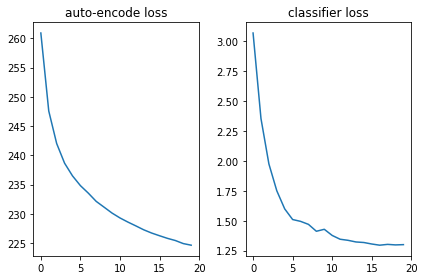

In [18]:
plt.subplot(121)
plt.plot(losses_auto_encode)
plt.title('auto-encode loss')

plt.subplot(122)
plt.plot(losses_digit_classifier)
plt.title('classifier loss')

plt.tight_layout()

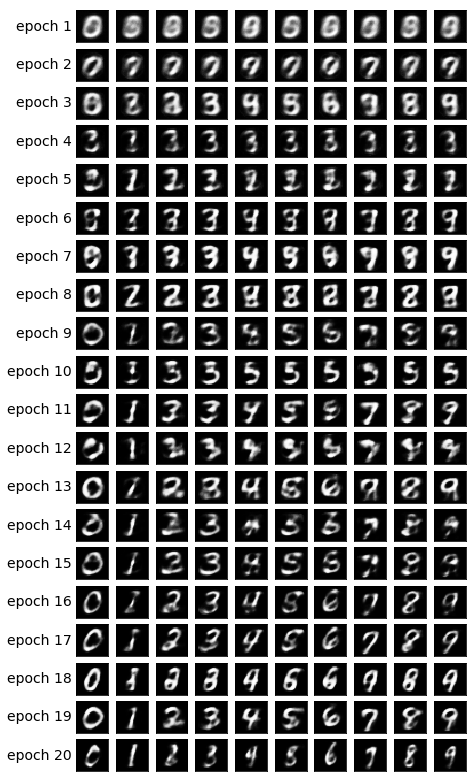

In [19]:
def plot_samples(samples, image_width=0.7):
    plt.figure(figsize=(image_width * num_digits, len(samples) * image_width))
    for epoch, images in enumerate(samples):
        for digit, image in enumerate(images):
            plt.subplot(len(samples), num_digits, epoch * num_digits + digit + 1)
            plt.imshow(image.reshape((28, 28)), cmap='Greys_r')
            plt.gca().xaxis.set_visible(False)
            if digit == 0:
                plt.gca().yaxis.set_ticks([])
                plt.ylabel('epoch {}'.format(epoch + 1),
                           verticalalignment='center',
                           horizontalalignment='right',
                           rotation=0,
                           fontsize=14)
            else:
                plt.gca().yaxis.set_visible(False)
                
                
plot_samples(samples)

# Final thoughts
It's nice to see that using a simple FF network (no fancy convolutions) we're able to generate nice looking images after merely 20 epochs. The model learnt to use the special digit dimensions quite fast - at epoch 9 we already see the sequence of digits we were trying to generate.

Every epoch used a different random values for the other dimensions, so we can see how the style differs between epochs, and is similar inside every epoch - at least for some of the epochs. At epoch 18 for instance all th digits are slightly bolder than epoch 20.